In [2]:
import pandas as pd
import psycopg2

conn = psycopg2.connect(dbname = 'opportunity_youth')

sql_str = "SELECT pwgtp, SCH, ESR, puma, agep FROM pums_2017 WHERE SCH = '1' and (ESR = '3' or ESR = '6') and (puma between '11610' and '11615') and (agep between '16' and '24')"
puma_num_totals = pd.read_sql(f"""SELECT puma, SUM(pwgtp) AS TotalPeople FROM ({sql_str}) AS a GROUP BY puma""", conn)

def youth_in_region(conn, conditions = ''):
    """
    Gets the approximate population from the pums 2017 database that are youth in south king county that also follow the given sql conditions

    Parameters
    ----------
    conn: connection to database
    conditions: extra sql conditions for the rows to follow

    Returns
    -------
    returns: sum of the population weights of the desired rows (this represents the population with the given conditions)
    """
    if conditions: conditions = " and " + conditions
    return pd.read_sql(f"""SELECT SUM(pwgtp) FROM pums_2017 WHERE (puma between '11610' and '11615') and (agep between '16' and '24'){conditions}""", conn)


def race_breakdown(conn, race_check_statement = ''):
    """
    Does sql calls that will get information about race breakdown for youth in south king county

    Parameters
    ----------
    race_check_statement: sql statement that will identify a certain race
    conn: Database connection

    Returns
    -------
    returns: dictionary of 4 population sums that match
             https://roadmapproject.org/wp-content/uploads/2018/09/Opportunity-Youth-2016-Data-Brief-v2.pdf
             page 2 of the race table given the race check statement
    """ 
    df_dict = {}
    has_no_ged = """(SCHL = '15' or SCHL = '01' or SCHL = '14' or SCHL = '13' or SCHL = '12' or SCHL = '11' or SCHL = '10' or SCHL = '9')"""
    df_dict['total'] =                      youth_in_region(conn, f"""{race_check_statement}""") # total of a race
    if race_check_statement: race_check_statement += ' and '
    df_dict['opportunity youth'] =          youth_in_region(conn, f"""{race_check_statement}SCH = '1' and (ESR = '3' or ESR = '6')""") # total OY of race
    df_dict['working without diploma'] =    youth_in_region(conn, f"""{race_check_statement}(SCH = '1')
                                                                                             and {has_no_ged}
                                                                                             and (ESR != '3' and ESR != '6')""") # working with no GED
    df_dict['not opportunity youth'] =      youth_in_region(conn, f"""{race_check_statement}((not {has_no_ged}
                                                                                             and (ESR != '3' and ESR != '6'))
                                                                                             or (SCH != '1'))""") # The rest of the age pop

    return df_dict



youth_in_region(conn, """SCH = '1' and (ESR = '3' or ESR = '6')""") # total
hisp = race_breakdown(conn, """RAC1P  = '8' and HISP != '01'""")
black = race_breakdown(conn, """RAC1P = '2'""")
white = race_breakdown(conn, """RAC1P = '1'""")
non_white = race_breakdown(conn, """RAC1P != '1' and RAC1P != '2' and RAC1P != '8' and HISP = '01'""")
all_race = {}
for i in hisp.keys(): all_race[i] = hisp[i] + black[i] + white[i] + non_white[i]


conn.close()

puma_num_totals['totalpeople'].sum()

10614.0

In [3]:
import os
import sys
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
from tabula import read_pdf
import numpy as np

%matplotlib inline

"""
Notes for making use of these methods

Types of methods
Split Method:     Splits a dataframe into multiple data frames with certain conditions. Returns a dictionary of these splits
Filter Method:    Filters a dataframe to follow a certain trait.
Breakdown Method: Takes a dataframe and breaks up the data into their respective categories and sums up the weighted population
                  This is like a split method but sums up the weights.
                  
!!!
Breakdown must make a total key if you want a table with percentage
!!!

All these methods are also usefull outside the breakdow_by_split method

breakdown_by_split will split a given dataframe, filter it (optional), and break it down
"""

def breakdown_by_split(df, split, breakdown, optional_filter = None):
    """
    Gives the oy breakdown by race for hispanic, black, white, and other

    Parameters
    ----------
    df: dataframe to be broken into race and then oportunity youth stats
    split: function that with split the tables into multiple tables
    breakdown: function that will break the tables into subcategories an get the sums
    optional_filter: if a function is given, this will filter each table after being split

    Returns
    -------
    Dictionary of dictionarys where the keys are the race and the values are the breakdown sums
    """
    dct = {}
    groups = split(df)
    for group in groups.keys():
        if optional_filter:
            dct[group] = breakdown(optional_filter(groups[group]))
        else:
            dct[group] = breakdown(groups[group])
    return dct

def filter_oy(df):
    """
    Gets OY from df
    """
    return df[(df['sch'] == '1') & ((df['esr'] == '3') | (df['esr'] == '6'))]

def split_by4_race(df):
    """
    Breaks the dataframe into hispanic, black, white, and other

    Parameters
    ----------
    df: data frame to be split up

    Returns
    -------
    dictionary of daraframes split by race
    """
    dct = {}
    dct['total']            = df.copy()
    dct['hispanic']         = df[(df['hisp'] != '01')]
    dct['african american'] = df[(df['rac1p'] == '2') & (df['hisp'] == '01')]
    dct['white']            = df[(df['rac1p'] == '1') & (df['hisp'] == '01')]
    dct['other']            = df[(df['rac1p'] != '1') & (df['rac1p'] != '2') & (df['hisp'] == '01')]
    return dct

def split_by_age(df):
    """
    Breaks the dataframe into 16-18, 19-21, 22-24

    Parameters
    ----------
    df: data frame to be split up

    Returns
    -------
    dictionary of daraframes split by age
    """
    dct = {}
    dct['total'] = df.copy()
    dct['16-18'] = df[((df['agep'] >= 16) & (df['agep'] <= 18))]
    dct['19-21'] = df[((df['agep'] >= 19) & (df['agep'] <= 21))]
    dct['22-24'] = df[((df['agep'] >= 22) & (df['agep'] <= 24))]
    return dct


def split_by_all_race(df):
    """
    Breaks the dataframe into many races

    Parameters
    ----------
    df: data frame to be split up

    Returns
    -------
    dictionary of daraframes split by race
    """
    dct = {}
    dct['total']                                = df.copy()
    dct['native american']                      = df[(df['rac1p'].isin(['3', '4', '5']) & (df['hisp'] == '01'))]
    dct['pacific islander and native hawaiian'] = df[(df['rac1p'].isin(['7']) & (df['hisp'] == '01'))]
    dct['african american']                     = df[(df['rac1p'].isin(['2']) & (df['hisp'] == '01'))]
    dct['hispanic']                             = df[((df['hisp'] != '01') & (df['rac1p'].isin(['8'])))] 
    dct['asian']                                = df[(df['rac1p'].isin(['6']) & (df['hisp'] == '01'))]
    dct['white']                                = df[(df['rac1p'].isin(['1']) & (df['hisp'] == '01'))]
    dct['two or more']                          = df[(df['rac1p'].isin(['9']) & (df['hisp'] == '01'))]
    dct['other']                                = df[(df['rac1p'].isin(['8']))]
    return dct

def oy_breakdown(df):
    """
    Breaks the dataframe into 4 dataframes and gives the number of people in that data frame the 4 dataframes are total, oy, working without diploma, not oy

    Parameters
    ----------
    df: dataframe to be brokendown

    Returns
    -------
    dictionary of the specified dataframe totals
    """
    dct = {}
    dct['total'] =      df['pwgtp'].sum() # total sum
    dct['oy'] =         filter_oy(df)['pwgtp'].sum() # not working and not in school
    dct['working'] =    df[(df['sch'] == '1')
                            & (df['schl'].isin(['15', '14', '13', '12', '11', '10', '09', '08', '07', '06', '05', '04', '03', '01']))
                            & ((df['esr'] != '3') & (df['esr'] != '6'))]['pwgtp'].sum() # working with no GED
    dct['not oy'] =     df[((~df['schl'].isin(['15', '14', '13', '12', '11', '10', '09', '08', '07', '06', '05', '04', '03', '01']) & ((df['esr'] != '3') & (df['esr'] != '6')))
                            | (df['sch'] != '1'))]['pwgtp'].sum() # either in school or working with a GED
    return dct

def education_breakdown(df):
    """
    Breaks the dataframe into education acheivment totals

    Parameters
    ----------
    df: dataframe to be broken into education achievement

    Returns
    -------
    Dictionary of the total number of people with education achievement level
    """
    dct = {}
    dct['total']        = df.copy()['pwgtp'].sum()
    dct['no diploma']   = df[df['schl'].isin(['15', '14', '13', '12', '11', '10', '09', '08', '07', '06', '05', '04', '03', '02', '01'])]['pwgtp'].sum()
    dct['diploma']      = df[df['schl'].isin(['16', '17'])]['pwgtp'].sum()
    dct['some college'] = df[df['schl'].isin(['18', '19'])]['pwgtp'].sum()
    dct['degree']       = df[df['schl'].isin(['20', '21', '22', '23', '24'])]['pwgtp'].sum()

    return dct





def make_table_with_percentage(dct): # TODO Comment on this
    """
    Makes a table with percentage with the top row being the total of entries bellow
    """
    df = __get_as_df(dct)
    return __add_percentage_column(df)

def make_table_without_percentage(dct):
    """
    Makes a table from a dictionary of dictionarys
    """
    return __get_as_df(dct)

def __get_as_df(dct):
    """
    Helper for make_table_with_percentage
    """
    df = pd.DataFrame(dct)
    df.columns = df.columns.str.title()
    cols = list(df.columns)
    if 'Total' in cols:
        cols.remove('Total')
        df = df[cols + ['Total']]
    df.index = df.index.str.title()
    return df

def __add_percentage_column(df):
    """
    Helper for make_table_with_percentage
    Adds a new column with the precentage preceding the each column
    Column names for the new columns are spaces
    """
    new_frame = df.copy()
    for index, column in enumerate(new_frame):
        new_frame[column] = new_frame[column].astype(int)
        new_frame.insert(index * 2, ' ' * index, (df[column] / df[column]['Total'] * 100).round().astype(int).astype(str) + '%')
    return new_frame

def __add_percentage_integrated(df):
    """
    Helper for make_table_with_percentage
    Addds the percentage to the columns
    """
    new_frame = df.copy()
    for column in new_frame:
        new_column = [str(int(round(100 * element / new_frame[column][0])))
                      + '% ' + str(int(element)) for element in new_frame[column]]
        new_frame[column] = new_column
    return new_frame

def page_2_dicts(df): # TODO Better comments!
    # Makes dictionarys for all the tables on page 2
    four_races     = breakdown_by_split(df, split_by4_race,    oy_breakdown)
    age            = breakdown_by_split(df, split_by_age,      oy_breakdown)
    edu_and_age    = breakdown_by_split(df, split_by_age,      education_breakdown, filter_oy)
    oy_by_all_race = breakdown_by_split(df, split_by_all_race, oy_breakdown)
    
    pop_by_race = {i : oy_by_all_race[i]['total'] for i in oy_by_all_race}  #  
    oy_by_race = {i : oy_by_all_race[i]['oy'] for i in oy_by_all_race}      # This transposes the dictionary
    race = {'Population Total' : pop_by_race, 'OY Total' : oy_by_race}      # 

    return four_races, age, edu_and_age, race

def page_2_tables(df): # TODO COMMENT MORE
    """
    df: dataframe of region and age range
    returns 4 dataframes that match the table on page 2 of the reference 2016 document
    """
    four_race_dict, age_dict, edu_dict, races_dict = page_2_dicts(df)

    four_race = make_table_with_percentage(four_race_dict)
    age       = make_table_with_percentage(age_dict)
    education = make_table_with_percentage(edu_dict)
    all_races = __fix_all_race_table(pd.DataFrame(races_dict))

    return four_race, age, education, all_races

def __fix_all_race_table(all_races): # TODO COMMENT!!!!
    """
    Helper method to add percentages to the all race table
    """
    new_col = ['100% ' + str(int(all_races['Population Total'][0]))]
    for index, element in enumerate(all_races['Population Total'][1:]):
        ratio = all_races['OY Total'][index + 1] / element
        new_col.append(str(int(round(100 * ratio))) + '% ' + str(int(element)))
    all_races['Population Total'] = new_col

    all_races['OY Total'] = [str(int(round(100 * element / all_races['OY Total'][0]))) + '% ' + str(int(element)) for element in all_races['OY Total']]
    all_races.index = all_races.index.str.title()
    return all_races


def get_youth_by_puma(start_puma = 11610, end_puma = 11615, dbname = 'opportunity_youth'):
    """
    Gives a table of youth from a given PUMA Range based on a given database name.
    Defaults are set for each parameter
    """
    conn = psycopg2.connect(dbname = dbname)
    df = pd.read_sql(f"SELECT * FROM pums_2017 WHERE (puma between '{start_puma}' and '{end_puma}') and (agep between '16' and '24')", conn)
    conn.close()
    return df

def get_oy_by_puma(start_puma = 11610, end_puma = 11615, dbname = 'opportunity_youth'):
    """
    Will Give a table of the OY for each PUMA in a range of pumas given from a given database
    Defaults are set for each parameter
    """
    sql_str = f"""SELECT pwgtp, SCH, ESR, puma, agep
                  FROM pums_2017
                  WHERE SCH = '1' and (ESR = '3' or ESR = '6') and (puma between '{start_puma}' and '{end_puma}') and (agep between '16' and '24')"""
    conn = psycopg2.connect(dbname = dbname)
    oy_by_puma = pd.read_sql(f"""SELECT puma, SUM(pwgtp) AS TotalPeople FROM ({sql_str}) AS a GROUP BY puma""", conn)
    conn.close()
    return oy_by_puma


In [4]:
# initialize df with rows of youth in the area
total_youth_unweighted = get_youth_by_puma(start_puma = 11610, end_puma = 11615, dbname = 'opportunity_youth')
oy_by_puma = get_oy_by_puma(start_puma = 11610, end_puma = 11615, dbname = 'opportunity_youth')
#oy_by_puma

In [5]:
four_race, age, education, all_races = page_2_tables(total_youth_unweighted) # all breakups as df
four_race_dct, age_dct, education_dct, all_races_dct = page_2_dicts(total_youth_unweighted) # all breakups as dct

In [12]:
df = total_youth_unweighted.copy()
dct = breakdown_by_split(df, lambda x: {'male' : x[x['sex'] == '1'], 'female' : x[x['sex'] == '2']}, oy_breakdown)
#dct = breakdown_by_split(df, lambda x: {'male' : x[x['sex'] == '1'], 'female' : x[x['sex'] == '2']}, education_breakdown)
#dct = breakdown_by_split(df, lambda x: {'self care difficulty' : x[x['ddrs'] == '1'], 'self care able' : x[x['ddrs'] == '2']}, oy_breakdown)
#dct = breakdown_by_split(df, lambda x: {'hearing difficulty' : x[x['dear'] == '1'], 'hearing able' : x[x['dear'] == '2']}, oy_breakdown)
#dct = breakdown_by_split(df, lambda x: {'vision difficulty' : x[x['deye'] == '1'], 'vision able' : x[x['deye'] == '2']}, oy_breakdown)
#dct = breakdown_by_split(df, lambda x: {'independent living difficulty' : x[x['dout'] == '1'], 'independent living able' : x[x['dout'] == '2']}, oy_breakdown)
#dct = breakdown_by_split(df, lambda x: {'ambulatory difficulty' : x[x['dphy'] == '1'], 'ambulatory able' : x[x['dphy'] == '2']}, oy_breakdown)
#make_table_with_percentage(dct)

In [31]:
def __remove_commas(df):
    new_df = df.copy()
    for col in new_df:
        new_df[col] = new_df[col].str.replace(',', '').astype(int)
    return new_df

def __get_frame_from_pdf():
    module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
    if module_path not in sys.path: sys.path.append(module_path)
    return read_pdf(module_path + "/references/Opportunity-Youth-2016-Data-Brief-v2.pdf", pages = 9)[0]

def get_2016_tables():
    df = __get_frame_from_pdf()
    df.columns = ['16-18','19-21','22-24','Total']
    oy = df.iloc[[0,1,2]]
    oy = pd.concat([pd.DataFrame([['50053', '41651', '48043', '139735']], columns = oy.columns), oy])
    oy.index = ['Total', 'Oy', 'Working', 'Not Oy']
    edu = df.iloc[[6,7,8,9]]
    edu = pd.concat([pd.DataFrame([['2805', '7284', '8728', '18817']], columns = edu.columns), edu])
    edu.index = ['Total', 'No diploma', 'diploma', 'some college', 'Degree']

    age_2016 = __remove_commas(oy)
    edu_2016 = __remove_commas(edu)
    age_2016 = make_table_with_percentage(age_2016)
    edu_2016 = make_table_with_percentage(edu_2016)
    return age_2016, edu_2016

def __get_percentage_columns(df):
    """
    isolates percent columns
    """
    new_cols = ' '.join(list(df.columns.str.replace(' ', ''))).split()
    new_df = df.loc[:, [i for i in df if not i.replace(' ', '')]]
    new_df.columns = new_cols
    return new_df

def __percentage_to_int(df):
    """
    All elements must be a str
    removes all % from every element
    """
    new_df = df.copy()
    for i in new_df:
        new_df[i] = new_df[i].str.replace('%', '').astype(int)
    return new_df

def table_compare_percents(table_list, name_list, x_label):
    """
    The tables must have a percent column for each column
    tables must have the same column header and indicies
    Currently only does this by row
    BUT it does allow for as many tables as you want!
    """
    
    table_list_percentage = []
    for table in table_list:
        table_list_percentage.append(__percentage_to_int(__get_percentage_columns(table)).drop('Total'))
    graph_by_row(table_list_percentage, name_list, x_label)
    
    t = []
    for table in table_list_percentage:
        t.append(table.transpose())
    graph_by_row(t, name_list, x_label)   



def graph_by_row(table_list, name_list, title):
    """
    Alot of code but it just makes plots for all the rows in a table with all the tables 
    """
    rows = len(table_list[0])
    fig, axes = plt.subplots(nrows = rows, ncols = 1, figsize = (len(table_list) * 5, rows * 8))
    x = np.arange(len(table_list[0].columns) + 0)
    width = 0.3
    counter = 0
    for table in table_list:
        row_num  = 0
        for index, row in table.iterrows():
            ax = axes[row_num]
            ax.bar(x + counter * width,
                   list(row), width = width,
                   color = ['b','g','r','y','k'][counter % 5],
                   align = 'center',
                   label = name_list[counter])
            ax.set_title(index, fontsize = 25)
            ax.set_ylabel('Percentage', fontsize = 15)
            ax.set_xlabel(title, fontsize = 15)
            ax.set_ylim(0, 100)
            ax.set_xticks(x + width / 2)
            ax.set_xticklabels(tuple(table.columns))
            ax.legend()
            row_num += 1
        counter += 1

In [19]:
age_2016, edu_2016 = get_2016_tables()

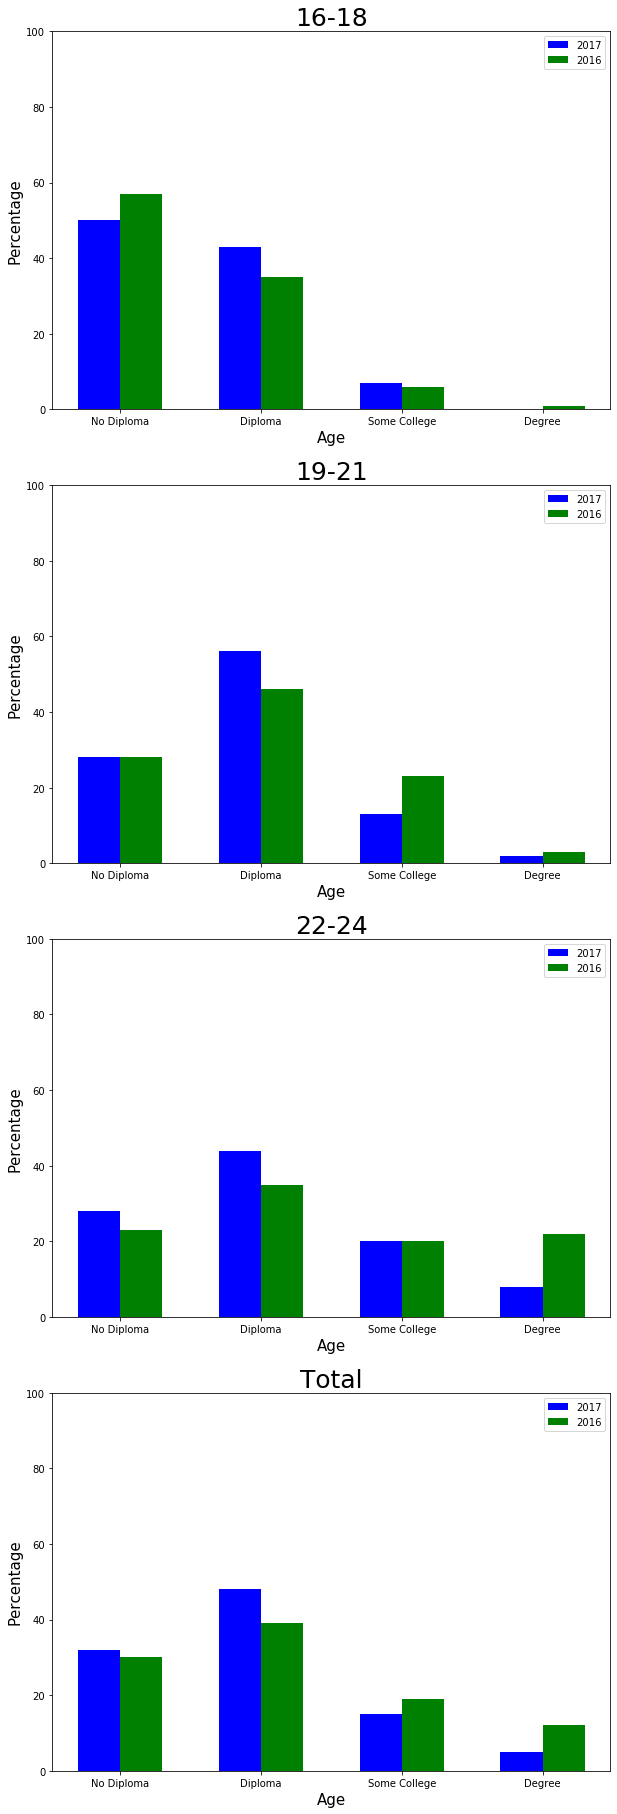

In [32]:

#table_compare_percents([age, age_2016], ['2017', '2016'], 'Age')
table_compare_percents([education, edu_2016], ['2017', '2016'], 'Age')


In [26]:
age

,,16-18,,19-21,,22-24,,Total
Total,100%,30141,100%,25486,100%,30256,100%,85883
Oy,6%,1815,15%,3902,16%,4897,12%,10614
Working,1%,449,5%,1400,5%,1631,4%,3480
Not Oy,92%,27877,79%,20184,78%,23728,84%,71789
